In [5]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import FixedLocator, LogLocator, LogFormatter, LogFormatterMathtext, NullFormatter

plt.rcParams['font.family'] = 'Nimbus Roman'
mpl.rcParams["text.usetex"] = True

# Data extraction

The data is stored as a dictionary of the basis set, a dictionary of the range-separated value

In [6]:
energy_per_omega_per_basis = {}
rij_init_time_per_omega_per_basis = {}
rij_per_iter_per_omega_per_basis = {}
xc_per_iter_per_omega_per_basis = {}

for basis in ["def2svp", "def2tzvp", "def2qzvp"]:
    df = pd.read_csv(f"data_{basis}_final.csv")

    cc_2e3c = df["2e3c-CC(s)"].astype(float).to_numpy()
    cd_2e3c = df["2e3c-CD(s)"].astype(float).to_numpy()
    sr_2e2c = df["2e2c(s)"].astype(float).to_numpy()
    rij_total_time = df["RIJ-BIGMEM(s)"].astype(float).to_numpy()
    xc_time = df["DFT-XC(s)"].astype(float).to_numpy()
    energy = df["Energy"].astype(float).to_numpy()
    niter = df["niter"].astype(float).to_numpy()

    omega = df["Omega"].astype(str).to_numpy()

    rij_init_time = cc_2e3c + cd_2e3c + sr_2e2c
    # Time per iteration for J build
    rij_per_iter = (rij_total_time - cc_2e3c - cd_2e3c - sr_2e2c) / niter
    # Time per iteration for XC
    xc_per_iter = xc_time / niter

    # Extract the data that belongs to similar range-separated omega value
    energy_per_omega = {}
    rij_init_time_per_omega = {}
    rij_per_iter_per_omega = {}
    xc_per_iter_per_omega = {}
    for w in range(len(omega)):
        key = omega[w]
        if key not in rij_init_time_per_omega:
            energy_per_omega[key] = []
            rij_init_time_per_omega[key] = []
            rij_per_iter_per_omega[key] = []
            xc_per_iter_per_omega[key] = []
        
        energy_per_omega[key].append(energy[w])
        rij_init_time_per_omega[key].append(rij_init_time[w])
        rij_per_iter_per_omega[key].append(rij_per_iter[w])
        xc_per_iter_per_omega[key].append(xc_per_iter[w])
        

    energy_per_omega_per_basis[basis] = energy_per_omega
    rij_init_time_per_omega_per_basis[basis] = rij_init_time_per_omega
    rij_per_iter_per_omega_per_basis[basis] = rij_per_iter_per_omega
    xc_per_iter_per_omega_per_basis[basis] = xc_per_iter_per_omega
    

# Plot runtime vs kpts

basis = def2svp
w = 0.3 has n = 0.14330953135734215
w = 0.6 has n = 0.03100021293550129
w = 0.9 has n = 0.013972223904259376
basis = def2tzvp
w = 0.3 has n = 0.3084666438223786
w = 0.6 has n = 0.0834259222026985
w = 0.9 has n = 0.03947840308082921
basis = def2qzvp
w = 0.3 has n = 0.1673559776144293
w = 0.6 has n = 0.03307252447075692
w = 0.9 has n = 0.016007945074858504


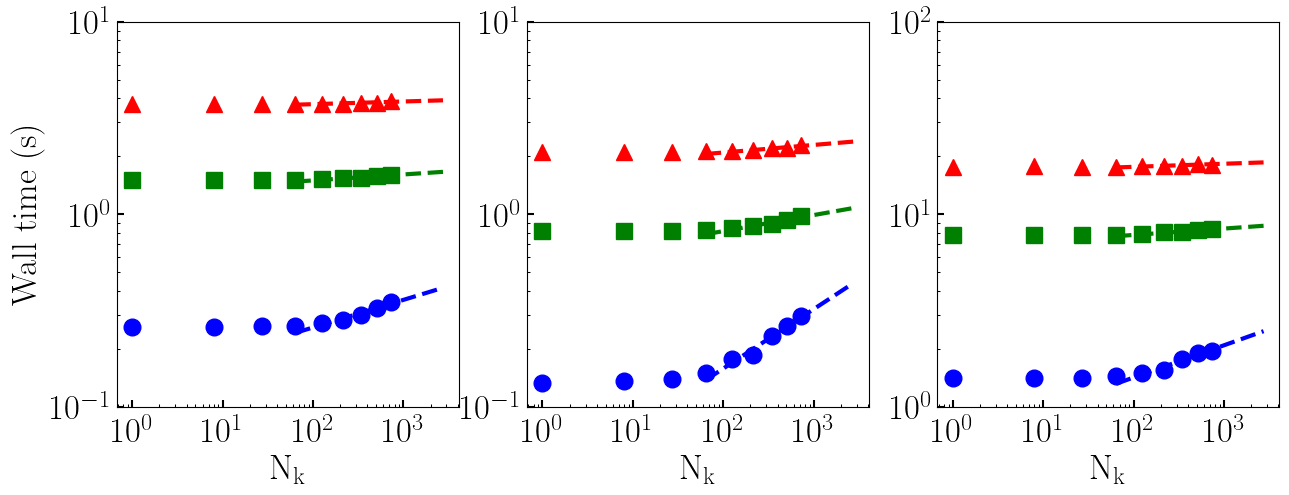

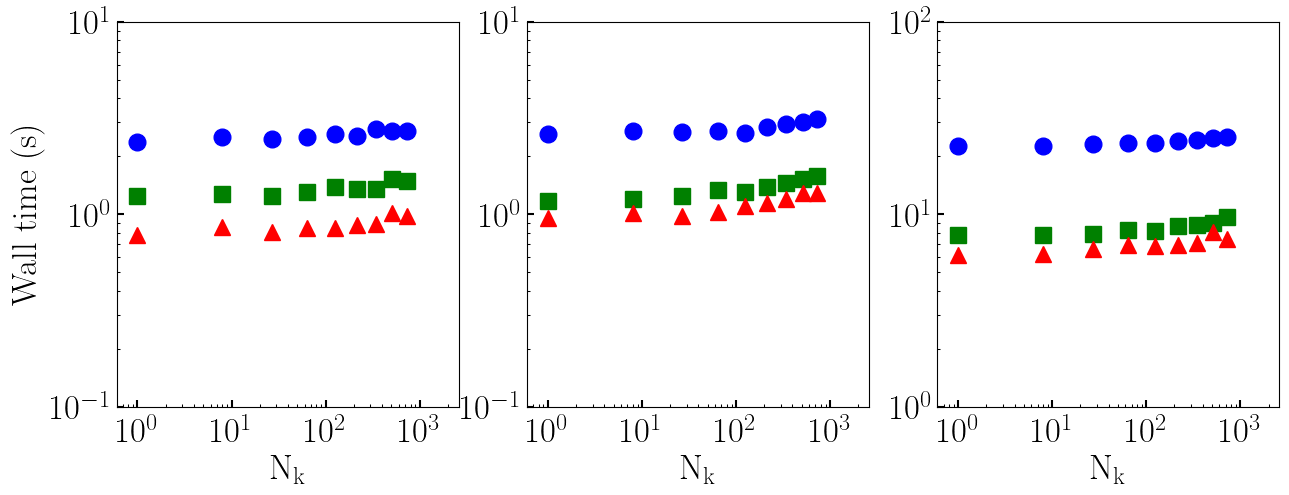

In [7]:
# Plot the data
omega_vals = ['0.3', '0.6', '0.9']
omega_labels = ['o', 's', '^']
nk = [i * i * i for i in [1,2,3,4,5,6,7,8,9]]
basis_series = ["def2svp", "def2tzvp", "def2qzvp"]
color_series = ["blue", "green", "red"]

fs = 25
ms = 12

# Fitting to get the k point dependence for each RI-J iteration
coeffs_per_omega_per_basis = {}

for ib in range(len(basis_series)):
    basis = basis_series[ib]
    print("================")
    print("basis =", basis)
    coeffs_per_omega = {}
    for idx in range(len(omega_vals)):
        w = omega_vals[idx]
        marker_type = omega_labels[idx]
        time = rij_per_iter_per_omega_per_basis[basis][w][-5:]
        
        log_nk = np.log(nk[-5:])
        log_rij_per_iter = np.log(time)
        coeffs = np.polyfit(log_nk, log_rij_per_iter, 1)
        n = coeffs[0]      # scaling exponent
        print("w = " + str(w) + " has n = " + str(n))
        coeffs_per_omega[w] = coeffs
        
    coeffs_per_omega_per_basis[basis] = coeffs_per_omega
# Fitting to get the k point dependence for each RI-J iteration [indexed by basis and by omega]


# RIJ per iteration
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for ib in range(len(basis_series)):
    basis = basis_series[ib]
    
    for idx in range(len(omega_vals)):
        w = omega_vals[idx]
        marker_type = omega_labels[idx]
        colors = color_series[idx]
        ax[ib].plot(nk, rij_per_iter_per_omega_per_basis[basis][w], marker = marker_type, color = colors, markersize=ms, linestyle="None", label = rf"$\omega = {w}$")
        
        # Plot the fitting line here
        coeffs = coeffs_per_omega_per_basis[basis][w]
        nk_fit = np.linspace(4**3, 14**3, 40)
        time_per_iter_fit = np.exp(coeffs[1]) * nk_fit**coeffs[0]
        
        ax[ib].plot(nk_fit, time_per_iter_fit, color = colors, linestyle="--", linewidth= 3)
    
    ax[ib].set_xlabel(r"N$_\mathrm{k}$", size = fs)
    ax[0].set_ylabel(r"Wall time (s)", size = fs)
    ax[ib].tick_params(axis='both', which='both', direction='in', labelsize= fs)
    ax[ib].set_yscale('log')
    ax[ib].set_xscale('log')
    
    ax[ib].set_xticks([1, 10, 100, 1000])
    ax[ib].tick_params(axis='x', which='major', length=5, width=1.5, pad=8)
    ax[ib].tick_params(axis='y', which='major', length=5, width=1.5)
    ax[ib].xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=10))
    ax[ib].tick_params(axis='x', which='minor', length=2.5, width=0.75)
    ax[ib].tick_params(axis='y', which='minor', length=2.5, width=0.75)
    
    # Set the limit for the time. Should span 2 decades since the kpoint vary by 2 decades here
    if basis == "def2svp" or basis == "def2tzvp":
        ax[ib].set_ylim(0.1, 10)
    else:
        ax[ib].set_ylim(1, 100)
    
    
    
# handles, labels = ax[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.08), fontsize=18, ncol=3)
# plt.show()

# RIJ init time
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for ib in range(len(basis_series)):
    basis = basis_series[ib]
    
    for idx in range(len(omega_vals)):
        w = omega_vals[idx]
        marker_type = omega_labels[idx]
        colors = color_series[idx]
        
        ax[ib].plot(nk, rij_init_time_per_omega_per_basis[basis][w], marker = marker_type, color = colors, markersize=ms, linestyle="None", label = rf"$\omega = {w}$")

    # ax[ib].set_title(f"RI-J init time ({basis})", size = 18)
    ax[ib].set_xlabel(r"N$_\mathrm{k}$", size = fs)
    ax[0].set_ylabel(r"Wall time (s)", size = fs)
    ax[ib].tick_params(axis='both', which='both', direction='in', labelsize=fs)
    ax[ib].set_yscale('log')
    ax[ib].set_xscale('log')
    
    ax[ib].set_xticks([1, 10, 100, 1000])
    ax[ib].tick_params(axis='x', which='major', length=5, width=1.5, pad=8)
    ax[ib].tick_params(axis='y', which='major', length=5, width=1.5)
    ax[ib].xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=10))
    ax[ib].tick_params(axis='x', which='minor', length=2.5, width=0.75)
    ax[ib].tick_params(axis='y', which='minor', length=2.5, width=0.75)
    
    if basis == "def2svp" or basis == "def2tzvp":
        ax[ib].set_ylim(0.1, 10)
    else:
        ax[ib].set_ylim(1, 100)

    ax[ib].set_xlim(0.6, 12 * 12 * 12 * 1.5)

marker_handles=[
    Line2D([0], [0], marker=omega_labels[0], color=color_series[0], markersize = ms, linestyle='None', label=r'$\omega$ = 0.3'),
    Line2D([0], [0], marker=omega_labels[1], color=color_series[1], markersize = ms, linestyle='None', label=r'$\omega$ = 0.6'),
    Line2D([0], [0], marker=omega_labels[2], color=color_series[2], markersize = ms, linestyle='None', label=r'$\omega$ = 0.9')
]

# fig.legend(handles=marker_handles,
#            loc='lower center',
#            bbox_to_anchor=(0.5, -0.7),   # adjust vertical offset
#            fontsize=fs,
#            ncol=3)

# handles, labels = ax[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.5), fontsize=fs, ncol=3)
plt.show()


# XC per iteration
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
# for ib in range(len(basis_series)):
#     basis = basis_series[ib]
    
#     for w in omega_vals:
#         ax[ib].plot(nk, xc_per_iter_per_omega_per_basis[basis][w], marker = "o", markersize=10, linestyle="--", label = rf"$\omega = {w}$")

#     ax[ib].set_title(f"XC per iter {basis}", size = 14)
#     ax[ib].set_xlabel(r"$N_k$", size = 14)
#     ax[0].set_ylabel(r"Wall time (s)", size = 14)
#     ax[ib].tick_params(axis='both', which='both', direction='in', labelsize=12)
#     ax[ib].set_yscale('log')
#     ax[ib].set_xscale('log')
#     ax[ib].legend()
# plt.show()

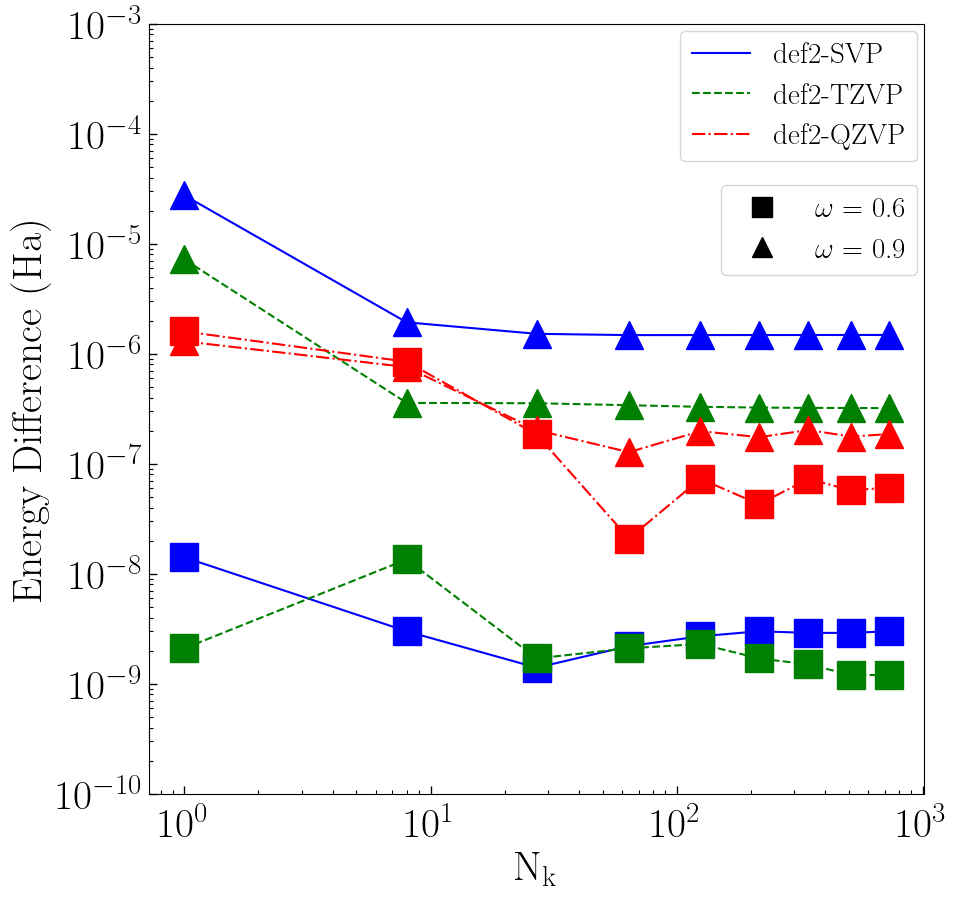

In [9]:
# Plot the absolute energies 
omega_vals = ['0.3', '0.6', '0.9']
nk = [i * i * i for i in range(1,10)]
omega_labels = ['o', 's', '^']
color_series = ["blue", "green", "red"]
line_style_series = ["-", "--", "-."]
basis_series = ["def2svp", "def2tzvp", "def2qzvp"]

ms = 20
fs = 30


# Converged energy at different omega
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
for ib in range(len(basis_series)):
    basis = basis_series[ib]
    colors = color_series[ib]
    line_style = line_style_series[ib]
    
    for idx in range(1, len(omega_vals)):
        w = omega_vals[idx]
        marker_type = omega_labels[idx]
        ax.plot(nk, np.abs(np.array(energy_per_omega_per_basis[basis][w]) - np.array(energy_per_omega_per_basis[basis]["0.3"])), marker = marker_type, color = colors,
                                    markersize=ms, linestyle = line_style, label = rf"$\omega = {w}$")

    # ax[ib].set_title(f"Energy ({basis})", size = 18)
    ax.set_xlabel(r"N$_\mathrm{k}$", size = fs, fontname="Nimbus Roman")
    ax.set_ylabel(r"Energy Difference (Ha)", size = fs, fontname="Nimbus Roman")
    ax.tick_params(axis='both', which='both', direction='in', labelsize = fs)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xticks([1, 10, 100, 1000])
    ax.set_yticks([10**-3,10**-4, 10**-5, 10**-6, 10**-7, 10**-8, 10**-9, 10**-10])
    
    ax.xaxis.set_minor_locator(LogLocator(base=10, subs=range(2,10)))
    ax.yaxis.set_minor_locator(LogLocator(base=10, subs=range(2,10)))
    ax.xaxis.set_minor_formatter(NullFormatter())  # show marks, no labels
    ax.yaxis.set_minor_formatter(NullFormatter())
    
    ax.tick_params(axis='x', which='minor', length=3, width=0.8, pad = 10)
    ax.tick_params(axis='y', which='minor', length=3, width=0.8)
    
    ax.tick_params(axis='x', which='major', length=6, width=0.8 * 1.2, pad = 10)
    ax.tick_params(axis='y', which='major', length=6, width=0.8 * 1.2)

    ax.set_ylim(top = 1e-3)
    ax.set_ylim(bottom = 1e-10)
    

basis_name = ["def2-SVP", "def2-TZVP", "def2-QZVP"]
    
line_legend = ax.legend(handles=[
    Line2D([0], [0], linestyle=line_style_series[0], color=color_series[0], label=basis_name[0]),
    Line2D([0], [0], linestyle=line_style_series[1], color=color_series[1], label=basis_name[1]),
        Line2D([0], [0], linestyle=line_style_series[2], color=color_series[2], label=basis_name[2]),
], loc='upper right', fontsize=fs * 0.7,bbox_to_anchor=(1.01, 1.01))

ax.add_artist(line_legend)  # keep this one fixed

marker_legend = ax.legend(handles=[
    Line2D([0], [0], marker='s', color='black', markersize = ms * 0.7, linestyle='None', label=r'$\omega$ = 0.6'),
    Line2D([0], [0], marker='^', color='black', markersize = ms * 0.7, linestyle='None', label=r'$\omega$ = 0.9')
], loc='upper right', fontsize=fs * 0.7,bbox_to_anchor=(1.01, 0.81))

plt.show()